# Medicine to Market | Why Do Clinical Trials Fail?

>In order to commercialize medical treatment in the United States, the treatment must complete clinical trials. These trials cost billions of dollars and years of effort. The failure of a clinical trial to be completed not only wastes money, but also prevents potentially life-saving treatments from reaching people who need it most.

## Goal for this Notebook:
Explore various reasons why clinical trials are not completed.

## Major Areas of Exploration:
* Study Types
* Phases
* Sources
* Number of Arms
* Number of Groups
* Intevention Types
* Sponsors
* State
* Number of Patients
* Interventions MeSH Categories
* Indications MeSH Categories

In [126]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
from patsy import dmatrices
import psycopg2 as pg
import pickle

from sklearn import preprocessing
from sklearn import cross_validation
from sklearn.model_selection import cross_val_score
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

import warnings; warnings.simplefilter('ignore')

condition_dict=pickle.load( open( "mesh_conditions.p", "rb" ) )
intervention_dict=pickle.load( open( "mesh_interventions.p", "rb" ) )

## Data Wrangling

In [2]:
connection=pg.connect("dbname=db user=user")

In [3]:
q_studies="""select studies.nct_id, 
                studies.overall_status,
                studies.study_type,
                studies.phase,
                studies.source,
                studies.number_of_arms,
                studies.number_of_groups
            from studies
            where (studies.overall_status like '%Completed%' or studies.overall_status like '%Terminated%')
            ;
"""

df_studies=pd.read_sql(q_studies, con=connection)
df_studies['overall_status'] = (df_studies['overall_status'] !='Terminated').astype(int)

In [4]:
q_sponsor="""select studies.nct_id,
                studies.overall_status,
                sponsors.name,
                sponsors.lead_or_collaborator
            from (sponsors inner join studies on sponsors.nct_id=studies.nct_id)
            where (studies.overall_status like '%Completed%' or 
                studies.overall_status like '%Terminated%') and
                (sponsors.lead_or_collaborator like '%lead%');
                
"""
df_sponsor=pd.read_sql(q_sponsor, con=connection)
df_sponsor['overall_status'] = (df_sponsor['overall_status'] !='Terminated').astype(int)

In [6]:
q_ivn_type="""select studies.nct_id,
        studies.overall_status,
        interventions.intervention_type 
    from (interventions left join studies on interventions.nct_id=studies.nct_id) 
    where (studies.overall_status like '%Completed%' or studies.overall_status like '%Terminated%');
"""

df_ivn_type=pd.read_sql(q_ivn_type, con=connection)
df_ivn_type['overall_status'] = (df_ivn_type['overall_status'] !='Terminated').astype(int)

In [9]:
q_fac_num="""select facilities.nct_id, count(facilities.nct_id)  
        from facilities group by nct_id;"""
df_fac_num=pd.read_sql(q_fac_num, con=connection)

In [11]:
q_fac_unique="""select distinct on (facilities.nct_id)
            facilities.nct_id,
            facilities.name,
            facilities.country,
            facilities.state
            from facilities;"""

df_fac_unique=pd.read_sql(q_fac_unique, con=connection)

In [10]:
q_basecounts="""select distinct on (studies.nct_id)
    studies.nct_id,
    studies.overall_status,
    baseline_counts.count
    from
        studies
    inner join baseline_counts on studies.nct_id=baseline_counts.nct_id
    where (studies.overall_status like '%Completed%' or studies.overall_status like '%Terminated%')
    order by studies.nct_id, baseline_counts.ctgov_group_code desc
    ;"""

df_basecounts=pd.read_sql(q_basecounts, con=connection)
df_basecounts['overall_status'] = (df_basecounts['overall_status'] !='Terminated').astype(int)

In [12]:
q_mesh_con="""select studies.nct_id, 
            studies.overall_status,
            browse_conditions.mesh_term
        from (browse_conditions inner join studies on browse_conditions.nct_id=studies.nct_id)
        where (studies.overall_status like '%Completed%' or studies.overall_status like '%Terminated%');
"""

df_mesh_con=pd.read_sql(q_mesh_con, con=connection)
df_mesh_con['overall_status'] = (df_mesh_con['overall_status'] !='Terminated').astype(int)
df_mesh_con.describe()

mesh_cat=[]
for row in df_mesh_con['mesh_term']:
        if row in condition_dict:
            mesh_cat.append(condition_dict[row])
        else:
            #mesh_cat.append(row) # keeps terms not in greater categories separate
            mesh_cat.append('Other')

df_mesh_con['mesh_cat']=pd.Series(mesh_cat, index=df_mesh_con.index)

df_mesh_copy=df_mesh_con.copy()
df_mesh_copy_dropmt=df_mesh_copy.drop('mesh_term',1)
df_mesh_nodups=df_mesh_copy_dropmt.drop_duplicates()

In [13]:
q_mesh_ivn="""select studies.nct_id,
            studies.overall_status,
            browse_interventions.mesh_term
        from (browse_interventions inner join studies on browse_interventions.nct_id=studies.nct_id)
        where (studies.overall_status like '%Completed%' or studies.overall_status like '%Terminated%');
"""

df_mesh_ivn=pd.read_sql(q_mesh_ivn, con=connection)
df_mesh_ivn['overall_status'] = (df_mesh_ivn['overall_status'] !='Terminated').astype(int)
df_mesh_ivn.describe()

mesh_ivn=[]
for row in df_mesh_ivn['mesh_term']:
        if row in intervention_dict:
            mesh_ivn.append(intervention_dict[row])
        else:
            #mesh_cat.append(row) # keeps terms not in greater categories separate
            mesh_ivn.append('Other')

df_mesh_ivn['mesh_ivn']=pd.Series(mesh_ivn, index=df_mesh_ivn.index)

# df_mesh_ivn.head()
df_ivn_copy=df_mesh_ivn.copy()
df_ivn_copy_dropmt=df_ivn_copy.drop('mesh_term',1)
df_ivn_nodups=df_ivn_copy_dropmt.drop_duplicates()

In [18]:
df_stud_spon=pd.merge(df_studies, df_sponsor, how='left', on='nct_id')
df_stud_spon_trim=df_stud_spon.drop(['overall_status_y','lead_or_collaborator'], 1)

df_ss_ivn=pd.merge(df_stud_spon_trim, df_ivn_type, how='left', on='nct_id')
df_ss_ivn_trim=df_ss_ivn.drop('overall_status',1)

df_ssi_fac_num=pd.merge(df_ss_ivn_trim, df_fac_num, how='left', on='nct_id')

df_ssif_fac_unique=pd.merge(df_ssi_fac_num, df_fac_unique, how='left', on='nct_id')

df_ssiff_basecounts=pd.merge(df_ssif_fac_unique, df_basecounts, how='left', on='nct_id')
df_ssiff_basecounts_trim=df_ssiff_basecounts.drop('overall_status',1)

df_ssiffb_mesh_con=pd.merge(df_ssiff_basecounts_trim, df_mesh_nodups, how='left', on='nct_id')
df_ssiffb_mesh_con_trim=df_ssiffb_mesh_con.drop('overall_status',1)

df_ssiffbc_mesh_ivn=pd.merge(df_ssiffb_mesh_con_trim, df_ivn_nodups, how='left', on='nct_id')
df_ssiffbci=df_ssiffbc_mesh_ivn.drop('overall_status',1)

df_comb=df_ssiffbci.rename(columns={'overall_status_x':'overall_status'})

In [20]:
df_all=df_comb.copy()
df_all['name_x'].replace(np.nan, 'Not Reported', inplace=True)
df_all['intervention_type'].replace(np.nan, 'Not Reported', inplace=True)
df_all['name_y'].replace(np.nan, 'Not Reported', inplace=True)
df_all['country'].replace(np.nan, 'Not Reported', inplace=True)
df_all['state'].replace(np.nan, 'Not Reported', inplace=True)
df_all['mesh_cat'].replace(np.nan, 'Not Reported', inplace=True)
df_all['mesh_ivn'].replace(np.nan, 'Not Reported', inplace=True)

df_all_fillna=df_all.fillna(0)

df_ivn_only_pre=df_all_fillna.copy()

df_ivn_only_pre2=df_ivn_only_pre[df_ivn_only_pre['study_type']=='Interventional']

df_ivn_only=df_ivn_only_pre2.drop('nct_id',1)

## Results

### Cancer and Other Neoplasms studies have the greatest number of terminated clinical trials.

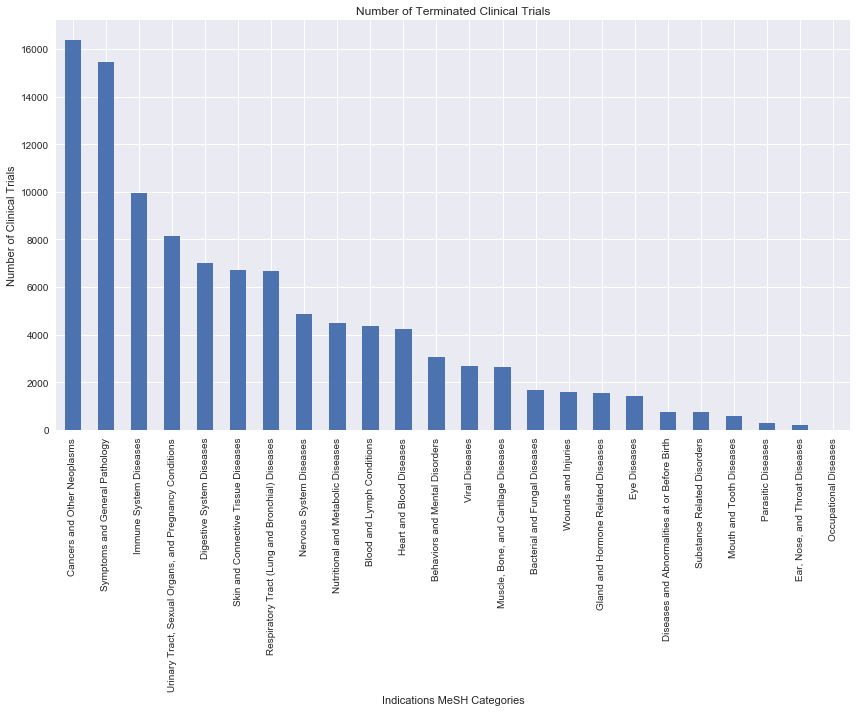

In [117]:
df_fig1_pre=df_ivn_only.loc[:,['overall_status','mesh_cat']]
df_fig1=df_fig1_pre.groupby(['mesh_cat','overall_status'])['mesh_cat'].count().unstack().fillna(0)

term_trials_pre=df_fig1[0].drop('Not Reported')
term_trials=term_trials_pre.drop('Other')

plt.figure(figsize=(12, 10))

ax = term_trials.sort_values(ascending=False).plot(kind='bar')
ax.set_ylabel("Number of Clinical Trials")
ax.set_xlabel("Indications MeSH Categories")

plt.title('Number of Terminated Clinical Trials')
plt.tight_layout()
plt.savefig('fig1.png')

In [119]:
term_trials.sort_values(ascending=False)

mesh_cat
Cancers and Other Neoplasms                               16380.0
Symptoms and General Pathology                            15438.0
Immune System Diseases                                     9962.0
Urinary Tract, Sexual Organs, and Pregnancy Conditions     8160.0
Digestive System Diseases                                  6998.0
Skin and Connective Tissue Diseases                        6734.0
Respiratory Tract (Lung and Bronchial) Diseases            6678.0
Nervous System Diseases                                    4869.0
Nutritional and Metabolic Diseases                         4478.0
Blood and Lymph Conditions                                 4350.0
Heart and Blood Diseases                                   4231.0
Behaviors and Mental Disorders                             3065.0
Viral Diseases                                             2667.0
Muscle, Bone, and Cartilage Diseases                       2660.0
Bacterial and Fungal Diseases                              1688.0
W

### Clinical Trials in Early Phase I and involving some sort of Phase 2 are most likely to terminate.

### Clinical Trials in Radiology are less likely to be completed than studies in Behavioral.

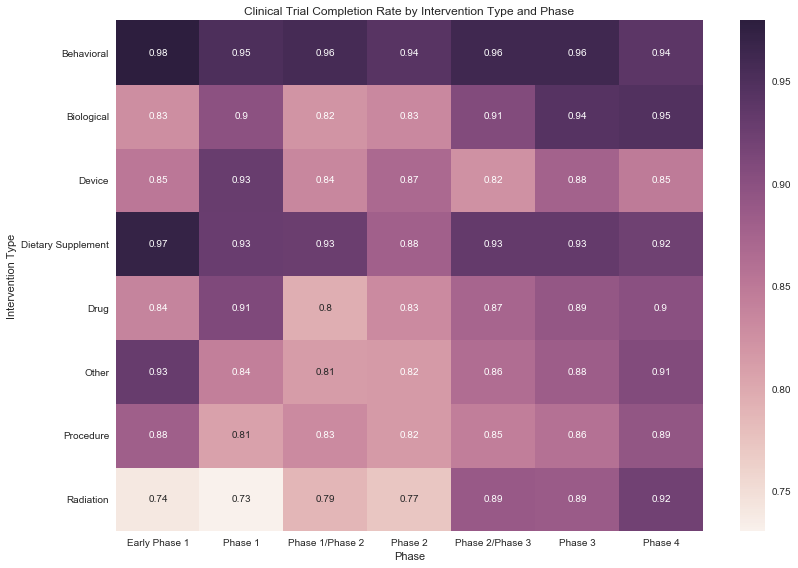

In [118]:
df_fig2_pre=df_ivn_only.loc[:,['overall_status','phase', 'intervention_type']]
df_fig2_pre2=df_fig2_pre.copy()
df_fig2_pre3=df_fig2_pre2[df_fig2_pre2['phase'] != 'N/A']
df_fig2_pre4=df_fig2_pre3[df_fig2_pre2['intervention_type'] != 'Not Reported']
df_fig2_pre5=df_fig2_pre4[df_fig2_pre2['intervention_type'] != 'Combination Product']
df_fig2_pre6=df_fig2_pre5[df_fig2_pre2['intervention_type'] != 'Diagnostic Test']
df_fig2_pre7=df_fig2_pre6[df_fig2_pre2['intervention_type'] != 'Genetic']

phase_ivn_type_pivot=pd.pivot_table(df_fig2_pre7, values='overall_status', index='intervention_type', columns='phase', aggfunc=np.mean)

plt.figure(figsize=(12, 8))
ax=sns.heatmap(phase_ivn_type_pivot, annot=True)
ax.set_xlabel('Phase')
ax.set_ylabel('Intervention Type')

plt.title('Clinical Trial Completion Rate by Intervention Type and Phase')
plt.tight_layout()
plt.savefig('fig2.png')

In [37]:
df_fig3_pre=df_ivn_only.loc[:,['overall_status','name_x']]

In [44]:
df_fig3=df_fig3_pre.groupby(['name_x','overall_status'])['name_x'].count().unstack().fillna(0)
df_fig3_sum=(df_fig3[0]+df_fig3[1])
df_fig3_avg=(df_fig3[1]/(df_fig3[0]+df_fig3[1]))
df_fig3['sum']=df_fig3_sum
df_fig3['avg']=df_fig3_avg
df_fig3_gt500=df_fig3[df_fig3['sum']>500].sort_values('avg', ascending=False)


### 10 sponsors have completed all of their clinical trials (having attempted at least 500 trials).

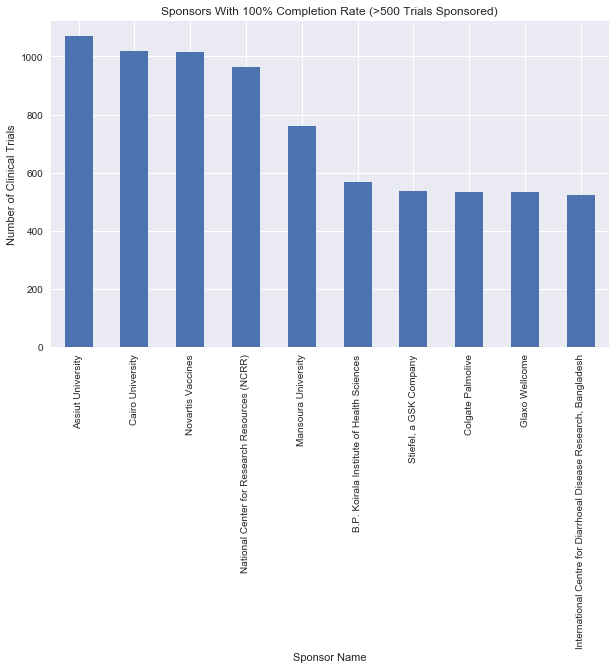

In [103]:
plt.figure(figsize=(10, 6))

ax=df_fig3_gt500.head(10).sort_values('sum', ascending=False)['sum'].plot(kind='bar')
ax.set_ylabel("Number of Clinical Trials")
ax.set_xlabel("Sponsor Name")

plt.title('Sponsors With 100% Completion Rate (>500 Trials Sponsored)')

### The ten sponsors with the lowest rate of clinical trial completion ranges from 11-58% (having attempted at least 500 trials).

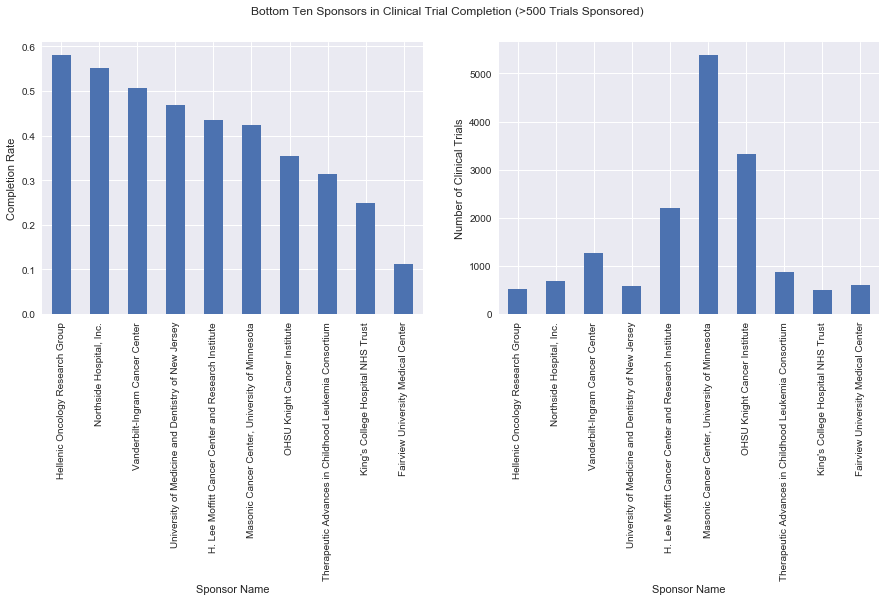

In [102]:
fig, axes =plt.subplots(nrows=1, ncols=2, figsize=(15,5))

ax1=df_fig3_gt500.tail(10).sort_values('avg', ascending=False)['avg'].plot(kind='bar', ax=axes[0])
ax1.set_ylabel("Completion Rate")
ax1.set_xlabel("Sponsor Name")
ax2=df_fig3_gt500.tail(10).sort_values('avg', ascending=False)['sum'].plot(kind='bar', ax=axes[1])
ax2.set_ylabel("Number of Clinical Trials")
ax2.set_xlabel("Sponsor Name")

plt.suptitle("Bottom Ten Sponsors in Clinical Trial Completion (>500 Trials Sponsored)")

In [128]:
df_fig3_gt500.tail(10).sort_values('avg', ascending=False)['avg']

name_x
Hellenic Oncology Research Group                         0.580153
Northside Hospital, Inc.                                 0.551320
Vanderbilt-Ingram Cancer Center                          0.507132
University of Medicine and Dentistry of New Jersey       0.467797
H. Lee Moffitt Cancer Center and Research Institute      0.435455
Masonic Cancer Center, University of Minnesota           0.423792
OHSU Knight Cancer Institute                             0.354819
Therapeutic Advances in Childhood Leukemia Consortium    0.314220
King's College Hospital NHS Trust                        0.250000
Fairview University Medical Center                       0.111842
Name: avg, dtype: float64

In [129]:
df_fig3_gt500.tail(10).sort_values('avg', ascending=False)['sum']

name_x
Hellenic Oncology Research Group                          524.0
Northside Hospital, Inc.                                  682.0
Vanderbilt-Ingram Cancer Center                          1262.0
University of Medicine and Dentistry of New Jersey        590.0
H. Lee Moffitt Cancer Center and Research Institute      2200.0
Masonic Cancer Center, University of Minnesota           5380.0
OHSU Knight Cancer Institute                             3320.0
Therapeutic Advances in Childhood Leukemia Consortium     872.0
King's College Hospital NHS Trust                         504.0
Fairview University Medical Center                        608.0
Name: sum, dtype: float64

In [ ]:
df_cancers_neoplasms_pre=df_ivn_only.copy()
df_cancers_neoplasms_pre2=df_cancers_neoplasms_pre[df_cancers_neoplasms_pre['mesh_cat']=='Cancers and Other Neoplasms']
df_cancers_neoplasms_pre3=df_cancers_neoplasms_pre2.drop('study_type',1)
#Drop facilities name
df_cancers_neoplasms=df_cancers_neoplasms_pre3.drop(['source','name_y'],1)

formula= 'overall_status ~ C(phase) + number_of_arms + number_of_groups + C(name_x) + C(intervention_type) + count_x + C(state) + count_y + C(mesh_cat)'
y,x = dmatrices(formula, data=df_cancers_neoplasms, return_type='dataframe')
y_flat=np.ravel(y)

validation_size = 0.20
seed = 7
scoring = 'accuracy'

X_train, X_test, y_train, y_test = cross_validation.train_test_split(x, y_flat, test_size=validation_size, random_state=seed)

models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.849444 (0.003843)
